# COVID-19 report analysis

Utilizes the daily data reporting from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE):
https://systems.jhu.edu/

Using the introductory Data Science Tables (for reference see http://data8.org/datascience/tables.html) of introductory courses

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Parsing and cleaning
def denan(v):
    return v if v != 'nan' else np.nan

def clean(tbl):
    for lbl in tbl.labels:
        tbl[lbl] = tbl.apply(denan, lbl)

def is_state(name):
    return not ',' in name
def is_county(name):
    return ',' in name
def getstate(name):
    county, state = name.split(', ')
    return state
def getcounty(name):
    county, state = name.split(', ')
    return county

# Tools for working with timestamps
def afterday(refday, day):
    return datetime.datetime.strptime(refday, "%m/%d/%y") <= datetime.datetime.strptime(day, "%m/%d/%y")

def after(trend, refday):
    return trend.where(trend.apply(lambda day: afterday(refday, day), trend.time_column))

In [3]:
# Tools for working with content
def by_country(raw_world):
    res = raw_world.drop(['Province/State', 'Lat', 'Long']).group('Country/Region', sum)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-4])
    return res

In [4]:
# Projecting growth rates

def incday(day, ndays=1):
    date =  datetime.datetime.strptime(day, "%m/%d/%y") + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, "%m/%d/%y")

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
    day = trend.last('Day')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = incday(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [5]:
# Pull the most recent data
if (not os.path.exists('./COVID-19')) :
    os.system('git clone https://github.com/CSSEGISandData/COVID-19')
else :
    os.system('pushd ./COVID19; git pull; popd')

In [6]:
# Raw data of confirmed cases
raw_confirmed = Table.read_table('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
raw_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
nan,Thailand,15,101,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411
nan,Japan,36,138,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007
nan,Singapore,1.2833,103.833,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432
nan,Nepal,28.1667,84.25,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
nan,Malaysia,2.5,112.5,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183
British Columbia,Canada,49.2827,-123.121,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,424
New South Wales,Australia,-33.8688,151.209,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436
Victoria,Australia,-37.8136,144.963,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229
Queensland,Australia,-28.0167,153.4,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,221
nan,Cambodia,11.55,104.917,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,5,7,7,7,33,35,37,51,53


In [7]:
raw_by_country = by_country(raw_confirmed)
countries_by_day = TimeTable.transpose(raw_by_country, 'Country/Region')
after(countries_by_day, "3/15/20")

Day,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,"Bahamas, The",Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Cape Verde,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cruise Ship,Cuba,Cyprus,Czechia,Denmark,Djibouti,Dominican Republic,East Timor,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,Gabon,"Gambia, The",Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Latvia,Lebanon,Liberia,Liechtenstein,Lithuania,Luxembourg,Madagascar,Malaysia,Maldives,Malta,Martinique,Mauritania,Mauritius,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Taiwan*,Tanzania,Thailand,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
3/15/20,16,42,48,1,0,1,45,26,297,860,23,0,214,5,0,27,886,0,1,10,24,162,50,51,3,0,7,2,252,0,1,0,74,81003,34,1,2,27,1,49,696,4,26,253,875,0,11,0,28,110,0,1,0,171,1,1,0,244,4523,1,0,33,5795,6,331,1,1,4,0,1,3,32,171,113,117,13938,116,129,251,24747,10,839,8,9,3,8162,2,112,0,30,110,0,4,12,59,0,428,13,21,9,1,0,41,23,2,1,0,28,2,1,1138,8,0,0,2,14,1221,22,53,43,0,6,43,140,119,245,401,131,63,1,2,1,101,103,24,48,2,226,54,219,0,51,7798,18,1,1,1022,2200,59,0,114,1,2,18,6,3499,0,3,98,1145,4,1,10,56,0,0
3/16/20,21,51,54,2,0,1,56,52,377,1018,15,1,214,8,0,36,1058,1,1,11,25,200,54,52,15,0,7,4,415,0,1,0,155,81033,54,1,2,35,1,57,696,4,33,298,933,0,11,0,37,150,0,1,0,205,1,5,0,277,6668,1,0,33,7272,6,331,2,1,4,0,1,6,39,180,119,134,14991,124,169,255,27980,10,825,17,10,3,8236,2,123,0,34,99,1,4,17,77,0,566,13,30,15,1,0,53,23,7,1,0,29,2,1,1416,8,0,0,2,18,1333,22,136,55,0,8,86,142,177,331,439,158,90,5,2,1,109,118,24,55,3,243,63,253,1,62,9942,28,1,1,1103,2200,67,1,147,1,4,20,18,4632,0,7,98,1551,8,6,17,61,0,0
3/17/20,22,55,60,39,0,1,68,78,452,1332,28,1,228,10,2,36,1243,1,1,11,26,321,56,67,15,0,33,10,478,0,1,0,201,81058,65,1,3,41,5,65,696,5,46,396,1025,0,21,0,58,196,0,1,0,225,1,5,0,321,7699,1,1,34,9257,7,387,6,1,7,0,1,8,50,220,142,172,16169,154,223,337,31506,12,878,34,33,3,8320,2,130,0,49,120,1,7,25,140,0,673,13,38,16,1,0,82,30,7,5,2,38,2,1,1711,12,0,0,3,26,1463,24,236,69,0,9,117,187,238,448,439,184,114,7,2,1,109,171,26,65,4,266,72,275,1,62,11748,44,1,1,1190,2700,77,1,177,1,5,24,47,6421,0,14,98,1960,29,10,33,66,0,0
3/18/20,22,59,74,39,0,1,79,84,568,1646,28,1,256,14,2,51,1486,2,1,12,38,372,68,92,20,0,35,10,657,0,1,0,238,81102,93,1,4,50,6,81,712,7,49,464,1116,1,21,0,111,196,0,4,0,258,1,6,0,336,9105,1,1,38,12327,7,418,6,1,7,0,1,9,58,250,156,227,17361,164,292,433,35713,13,889,52,35,3,8413,2,142,3,71,133,2,28,27,203,0,790,13,38,19,1,3,93,30,7,6,1,49,2,1,2058,20,0,0,8,35,1550,39,299,86,0,11,145,202,251,448,452,260,147,8,2,1,119,171,31,83,4,313,105,275,1,116,13910,51,2,1,1279,3028,100,3,212,1,7,29,98,7783,0,14,113,2642,50,15,36,75,2,0
3/19/20,22,64,87,53,0,1,97,115,681,2013,44,3,278,17,5,51,1795,2,1,12,63,621,75,94,33,0,37,13,800,0,1,1,238,81156,102,3,14,69,9,105,712,11,67,694,1225,1,34,0,199,256,1,6,0,267,1,6,1,400,10947,1,1,40,15320,11,418,9,1,7,0,1,12,73,330,194,311,18407,192,557,677,41035,15,924,69,44,7,8565,2,148,3,86,157,2,28,36,335,0,900,13,53,23,2,3,118,49,7,6,3,63,3,1,2467,28,1,0,8,48,1746,48,454,109,0,11,234,217,35

In [8]:
# What is the last day reported
countries_by_day.last('Day')

'3/21/20'

### How many of the 195 recognized countries in the world have reported cases?

This does include some non-countries, like Princess Cruises

In [9]:
raw_by_country.num_rows

166

### Total confirmed cases worldwide

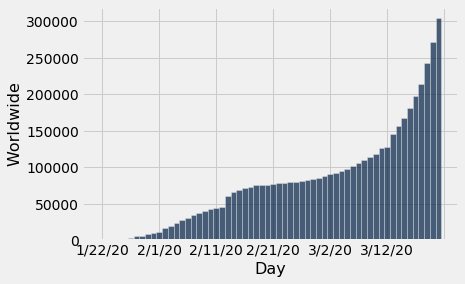

In [10]:
total_confirmed = countries_by_day.select('Day')
total_confirmed['Worldwide'] = countries_by_day.sum_rows()
total_confirmed.obar()

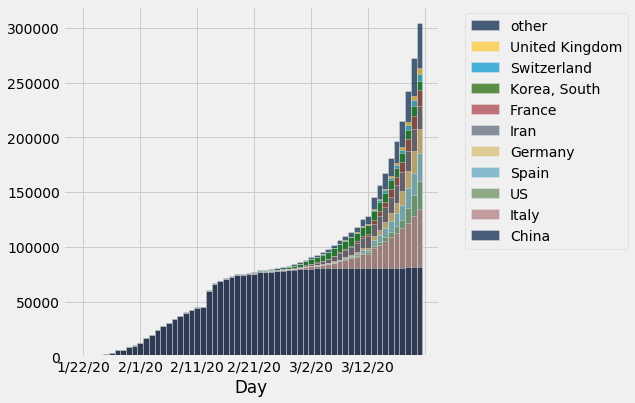

In [11]:
# Breaking this picture down by largest caseloads

countries_by_day.stackbar(10, height=6)

In [12]:
# Recent picture of countries with most cases
countries_by_day.top(15).take[-10:]

Day,China,Italy,US,Spain,Germany,Iran,France,"Korea, South",Switzerland,United Kingdom,Netherlands,Belgium,Austria,Norway,Sweden
3/12/20,80932,12462,1663,2277,2078,10075,2290,7869,652,459,503,314,302,702,599
3/13/20,80945,17660,2179,5232,3675,11364,3678,7979,1139,802,806,559,504,996,814
3/14/20,80977,21157,2727,6391,4585,12729,4487,8086,1359,1144,962,689,655,1090,961
3/15/20,81003,24747,3499,7798,5795,13938,4523,8162,2200,1145,1138,886,860,1221,1022
3/16/20,81033,27980,4632,9942,7272,14991,6668,8236,2200,1551,1416,1058,1018,1333,1103
3/17/20,81058,31506,6421,11748,9257,16169,7699,8320,2700,1960,1711,1243,1332,1463,1190
3/18/20,81102,35713,7783,13910,12327,17361,9105,8413,3028,2642,2058,1486,1646,1550,1279
3/19/20,81156,41035,13677,17963,15320,18407,10947,8565,4075,2716,2467,1795,2013,1746,1439
3/20/20,81250,47021,19100,20410,19848,19644,12726,8652,5294,4014,3003,2257,2388,1914,1639
3/21/20,81305,53578,25489,25374,22213,20610,14431,8799,6575,5067,3640,2815,2814,2118,1763


In [13]:
total_confirmed.trend().take[-10:]

Day,Worldwide,new,% new,rate
3/12/20,128343,2478,1.93%,1.01969
3/13/20,145193,16850,11.61%,1.13129
3/14/20,156094,10901,6.98%,1.07508
3/15/20,167446,11352,6.78%,1.07273
3/16/20,181527,14081,7.76%,1.08409
3/17/20,197142,15615,7.92%,1.08602
3/18/20,214910,17768,8.27%,1.09013
3/19/20,242708,27798,11.45%,1.12935
3/20/20,272166,29458,10.82%,1.12137
3/21/20,304524,32358,10.63%,1.11889


In [14]:
project_trend(total_confirmed.trend().take[-10:], 10).show()

Day,Worldwide,new,% new,rate
3/12/20,128343,2478,1.93%,1.01969
3/13/20,145193,16850,11.61%,1.13129
3/14/20,156094,10901,6.98%,1.07508
3/15/20,167446,11352,6.78%,1.07273
3/16/20,181527,14081,7.76%,1.08409
3/17/20,197142,15615,7.92%,1.08602
3/18/20,214910,17768,8.27%,1.09013
3/19/20,242708,27798,11.45%,1.12935
3/20/20,272166,29458,10.82%,1.12137
3/21/20,304524,32358,10.63%,1.11889


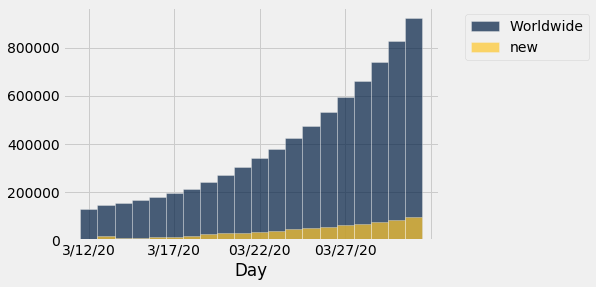

In [15]:
project_trend(total_confirmed.trend().take[-10:], 10).select(range(3)).bar('Day')

In [16]:
countries_by_day.top(5).trend().take[-10:]

Day,China,new China,% newChina,rate China,Italy,new Italy,% newItaly,rate Italy,US,new US,% newUS,rate US,Spain,new Spain,% newSpain,rate Spain,Germany,new Germany,% newGermany,rate Germany
3/12/20,80932,11,0.01%,1.00014,12462,0,0.00%,1,1663,382,22.97%,1.2982,2277,0,0.00%,1,2078,170,8.18%,1.0891
3/13/20,80945,13,0.02%,1.00016,17660,5198,29.43%,1.41711,2179,516,23.68%,1.31028,5232,2955,56.48%,2.29776,3675,1597,43.46%,1.76853
3/14/20,80977,32,0.04%,1.0004,21157,3497,16.53%,1.19802,2727,548,20.10%,1.25149,6391,1159,18.13%,1.22152,4585,910,19.85%,1.24762
3/15/20,81003,26,0.03%,1.00032,24747,3590,14.51%,1.16968,3499,772,22.06%,1.28309,7798,1407,18.04%,1.22015,5795,1210,20.88%,1.2639
3/16/20,81033,30,0.04%,1.00037,27980,3233,11.55%,1.13064,4632,1133,24.46%,1.32381,9942,2144,21.57%,1.27494,7272,1477,20.31%,1.25487
3/17/20,81058,25,0.03%,1.00031,31506,3526,11.19%,1.12602,6421,1789,27.86%,1.38623,11748,1806,15.37%,1.18165,9257,1985,21.44%,1.27296
3/18/20,81102,44,0.05%,1.00054,35713,4207,11.78%,1.13353,7783,1362,17.50%,1.21212,13910,2162,15.54%,1.18403,12327,3070,24.90%,1.33164
3/19/20,81156,54,0.07%,1.00067,41035,5322,12.97%,1.14902,13677,5894,43.09%,1.75729,17963,4053,22.56%,1.29137,15320,2993,19.54%,1.2428
3/20/20,81250,94,0.12%,1.00116,47021,5986,12.73%,1.14588,19100,5423,28.39%,1.39651,20410,2447,11.99%,1.13622,19848,4528,22.81%,1.29556
3/21/20,81305,55,0.07%,1.00068,53578,6557,12.24%,1.13945,25489,6389,25.07%,1.3345,25374,4964,19.56%,1.24321,22213,2365,10.65%,1.11916


### Confirmed cases in one country

In [17]:
w = widgets.Dropdown(
    options=countries_by_day.categories,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
w

Dropdown(description='Country:', index=155, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',…

In [18]:
country = w.value

In [19]:
country_trend = countries_by_day.extract(country).trend()
after(country_trend, '3/5/20').show()

Day,US,new,% new,rate
3/5/20,217,68,0.313364,1.45638
3/6/20,262,45,0.171756,1.20737
3/7/20,402,140,0.348259,1.53435
3/8/20,518,116,0.223938,1.28856
3/9/20,583,65,0.111492,1.12548
3/10/20,959,376,0.392075,1.64494
3/11/20,1281,322,0.251366,1.33577
3/12/20,1663,382,0.229705,1.2982
3/13/20,2179,516,0.236806,1.31028
3/14/20,2727,548,0.200953,1.25149


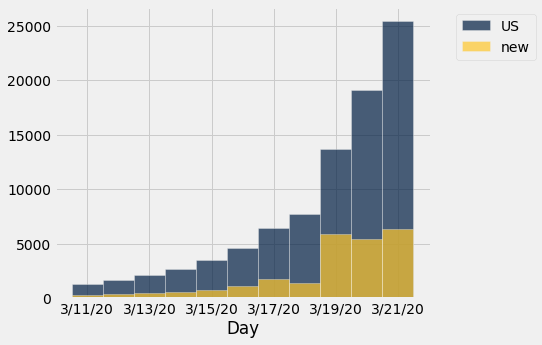

In [20]:
recent = after(country_trend,'3/11/20')
recent.extract([country, 'new']).bar('Day', height=5)

In [21]:
projection = project_trend(recent, 10)
projection.show()

Day,US,new,% new,rate
3/11/20,1281,322,0.251366,1.33577
3/12/20,1663,382,0.229705,1.2982
3/13/20,2179,516,0.236806,1.31028
3/14/20,2727,548,0.200953,1.25149
3/15/20,3499,772,0.220634,1.28309
3/16/20,4632,1133,0.244603,1.32381
3/17/20,6421,1789,0.278617,1.38623
3/18/20,7783,1362,0.174997,1.21212
3/19/20,13677,5894,0.430942,1.75729
3/20/20,19100,5423,0.283927,1.39651


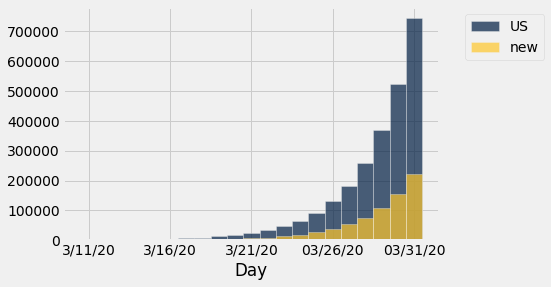

In [22]:
projection.extract([country, 'new']).bar('Day')

### State/Province level

What countries are further broken down by state

In [23]:
countries_with_states = list(np.unique(raw_confirmed.where(raw_confirmed['Province/State'] != 'nan')['Country/Region']))

cw = widgets.Dropdown(
    options=countries_with_states,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
cw

Dropdown(description='Country:', index=7, options=('Australia', 'Canada', 'China', 'Cruise Ship', 'Denmark', '…

In [24]:
sel_country = cw.value
sel_country

'US'

In [25]:
raw_sel_confirmed = raw_confirmed.where('Country/Region', sel_country)
raw_sel_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Washington,US,47.4009,-121.49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014,1376,1524,1793
New York,US,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495,5365,8310,11710
California,US,36.1162,-119.682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751,952,1177,1364
Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218,328,413,525
Diamond Princess,US,35.4437,139.638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,49,49
Grand Princess,US,37.6489,-122.665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,21,21,21,21,21,21,21,21,20,21,21,22,23,23
Georgia,US,33.0406,-83.6431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,23,31,42,66,99,121,146,199,287,420,507
Colorado,US,39.0598,-105.311,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,34,45,49,101,131,160,160,184,277,363,390
Florida,US,27.7663,-81.6868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,28,35,50,76,115,155,216,314,417,563,659
New Jersey,US,40.2989,-74.521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,23,29,29,69,98,178,267,267,742,890,1327


In [26]:
raw_by_State_confirmed = raw_sel_confirmed.where(raw_sel_confirmed.apply(is_state, 'Province/State'))
states_by_day = TimeTable.transpose(raw_by_State_confirmed.drop(['Country/Region', 'Lat', 'Long']), 'Province/State', 'Day')
recent_by_State = after(states_by_day,'3/10/20')
recent_by_State = recent_by_State.order_cols()
recent_by_State.show()

Day,New York,Washington,California,New Jersey,Michigan,Illinois,Florida,Louisiana,Texas,Massachusetts,Georgia,Pennsylvania,Colorado,Tennessee,Wisconsin,North Carolina,Ohio,Connecticut,Maryland,South Carolina,Nevada,Virginia,Mississippi,Minnesota,Utah,Alabama,Indiana,Arkansas,Arizona,Oregon,Kentucky,District of Columbia,Missouri,Maine,Iowa,Rhode Island,Kansas,New Hampshire,Oklahoma,Diamond Princess,Delaware,New Mexico,Nebraska,Hawaii,Idaho,Vermont,North Dakota,Grand Princess,Wyoming,Montana,Puerto Rico,Alaska,Guam,South Dakota,West Virginia,Virgin Islands
3/10/20,173,267,144,15,0,12,15,1,13,92,17,12,15,7,3,7,3,2,8,7,4,7,0,3,2,0,6,0,6,15,6,5,1,0,8,3,1,4,2,46,0,0,3,2,0,1,0,21,0,0,0,0,0,0,0,0
3/11/20,220,366,177,23,2,25,28,6,21,95,23,16,34,9,6,7,4,3,9,10,7,9,0,5,3,0,11,1,9,19,8,10,1,0,13,5,1,5,2,46,1,3,5,2,0,1,0,21,0,1,0,0,0,8,0,0
3/12/20,328,442,221,29,2,32,35,19,27,108,31,22,45,18,8,15,5,5,12,12,14,17,1,9,5,0,13,6,9,24,10,10,1,0,16,5,1,6,2,46,1,5,10,2,0,2,1,21,1,1,0,0,0,8,0,0
3/13/20,421,568,282,29,16,46,50,36,43,123,42,41,49,26,19,17,13,11,18,13,17,30,1,14,9,5,13,6,9,30,14,10,2,1,17,14,5,6,2,46,4,10,13,2,1,2,1,21,1,1,0,1,0,8,0,0
3/14/20,525,572,340,69,25,64,76,77,57,138,66,47,101,32,27,24,26,22,26,19,21,41,6,21,10,6,16,12,12,32,14,10,4,3,17,20,8,7,4,46,6,10,14,4,2,5,1,21,2,5,3,1,0,9,0,1
3/15/20,732,643,426,98,33,93,115,91,72,164,99,66,131,39,32,33,37,24,32,28,24,45,10,35,28,12,20,16,13,36,20,16,5,12,18,20,8,13,7,46,7,13,17,6,5,8,1,21,3,7,5,1,3,9,0,1
3/16/20,967,904,557,178,53,105,155,136,85,197,121,77,160,52,47,38,50,30,41,33,45,49,13,54,39,29,25,22,18,39,21,22,6,17,23,21,11,17,10,47,8,17,18,7,5,12,1,20,3,7,5,1,3,10,0,1
3/17/20,1706,1076,698,267,65,161,216,196,110,218,146,112,160,74,72,64,67,68,60,47,56,67,21,60,51,39,30,22,20,66,26,22,11,32,23,23,18,26,19,47,16,23,21,10,8,12,3,21,11,9,5,3,3,11,1,2
3/18/20,2495,1014,751,267,83,162,314,257,173,218,199,152,184,79,92,70,86,68,85,47,55,77,34,77,51,46,39,33,27,68,27,31,18,42,29,33,18,26,19,47,19,23,24,14,9,18,6,21,15,11,5,6,5,11,1,2
3/19/20,5365,1376,952,742,334,422,417,392,260,328,287,206,277,154,159,123,119,159,107,81,95,99,50,89,80,78,60,62,45,88,37,40,31,52,44,44,34,44,44,47,30,35,29,16,11,22,18,22,18,11,5,9,12,11,2,3


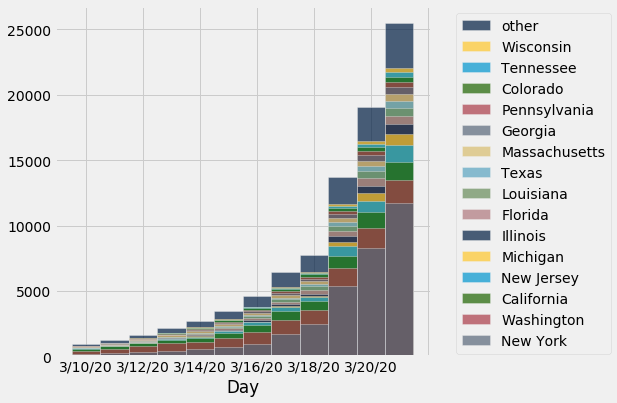

In [27]:
recent_by_State.stackbar(15, height=6)

# State level analysis

In [28]:
sw = widgets.Dropdown(
    options=recent_by_State.categories,
    value=recent_by_State.categories[0],
    # rows=10,
    description='State/Province:',
    disabled=False
)
sw

Dropdown(description='State/Province:', options=('New York', 'Washington', 'California', 'New Jersey', 'Michig…

In [29]:
state = sw.value

In [30]:
state_trend = recent_by_State.extract(state).trend()
state_trend

Day,New York,new,% new,rate
3/10/20,173,nan,nan%,nan
3/11/20,220,47,21.36%,1.27168
3/12/20,328,108,32.93%,1.49091
3/13/20,421,93,22.09%,1.28354
3/14/20,525,104,19.81%,1.24703
3/15/20,732,207,28.28%,1.39429
3/16/20,967,235,24.30%,1.32104
3/17/20,1706,739,43.32%,1.76422
3/18/20,2495,789,31.62%,1.46249
3/19/20,5365,2870,53.49%,2.1503


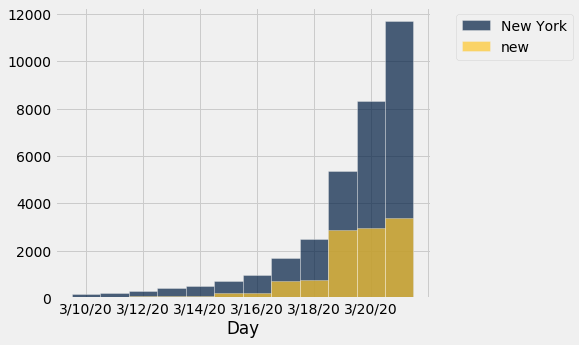

In [31]:
state_trend.extract(['Day', state, 'new']).bar('Day', height=5)

In [32]:
project_trend(state_trend, 10).show()

Day,New York,new,% new,rate
3/10/20,173,nan,nan,nan
3/11/20,220,47,0.213636,1.27168
3/12/20,328,108,0.329268,1.49091
3/13/20,421,93,0.220903,1.28354
3/14/20,525,104,0.198095,1.24703
3/15/20,732,207,0.282787,1.39429
3/16/20,967,235,0.24302,1.32104
3/17/20,1706,739,0.433177,1.76422
3/18/20,2495,789,0.316232,1.46249
3/19/20,5365,2870,0.534949,2.1503


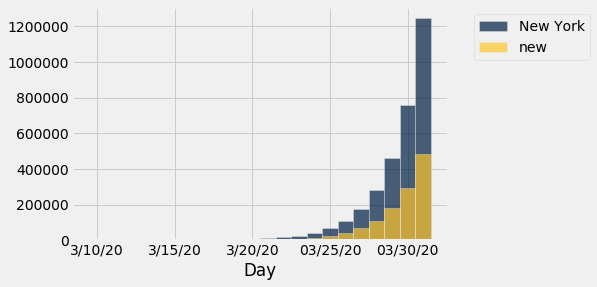

In [33]:
project_trend(state_trend, 10).extract([state, 'new']).bar('Day')

### County level reporting - not there recently

In [34]:
raw_US_confirmed = raw_confirmed.where('Country/Region', 'US')
raw_US_by_County_confirmed = raw_US_confirmed.where(raw_US_confirmed.apply(is_county, 'Province/State'))
raw_US_by_County_confirmed['State'] = raw_US_by_County_confirmed.apply(getstate, 'Province/State')
raw_US_by_County_confirmed['County'] = raw_US_by_County_confirmed.apply(getcounty, 'Province/State')
raw_US_by_County_confirmed.move_to_start('County')
raw_US_by_County_confirmed.move_to_start('State')
raw_US_by_County_confirmed.sort('State')

State,County,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
AZ,Pima,"Pima, AZ",US,32.0575,-111.666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,Pinal County,"Pinal County, AZ",US,32.8162,-111.284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0
AZ,Maricopa County,"Maricopa County, AZ",US,33.2918,-112.429,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0
CA,Solano,"Solano, CA",US,38.3105,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Santa Cruz,"Santa Cruz, CA",US,37.0454,-121.958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Napa,"Napa, CA",US,38.5025,-122.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Ventura,"Ventura, CA",US,34.3705,-119.139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Shasta County,"Shasta County, CA",US,40.7909,-121.847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Fresno County,"Fresno County, CA",US,36.9859,-119.232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Riverside County,"Riverside County, CA",US,33.9533,-117.396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
raw_US_by_County_confirmed.where('State', 'CA')

State,County,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
CA,Solano,"Solano, CA",US,38.3105,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Santa Cruz,"Santa Cruz, CA",US,37.0454,-121.958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Napa,"Napa, CA",US,38.5025,-122.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Ventura,"Ventura, CA",US,34.3705,-119.139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,Shasta County,"Shasta County, CA",US,40.7909,-121.847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Fresno County,"Fresno County, CA",US,36.9859,-119.232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Riverside County,"Riverside County, CA",US,33.9533,-117.396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Alameda County,"Alameda County, CA",US,37.6017,-121.719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0
CA,Madera County,"Madera County, CA",US,37.2519,-119.696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
CA,Yolo County,"Yolo County, CA",US,38.7646,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
raw_CA_county = raw_US_by_County_confirmed.where('State', 'CA').drop(['State', 'Province/State', 'Country/Region', 'Lat', 'Long'])
CA_county_by_day = TimeTable.transpose(raw_CA_county, 'County', 'Day')
CA_county_by_day.show()

Day,Solano,Santa Cruz,Napa,Ventura,Shasta County,Fresno County,Riverside County,Alameda County,Madera County,Yolo County,Santa Clara County,San Francisco County,Contra Costa County,Orange County,Placer County,San Mateo,Sonoma County,Humboldt County,Sacramento County,San Diego County,San Benito,Los Angeles,Marin,Calaveras,Stanislaus,San Joaquin
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/27/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/28/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/29/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/30/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/31/20,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
